In [4]:
#Generating New dataset using MNIST

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Lambda , Input ,Dense
from keras.losses import binary_crossentropy
from keras.models import Model 
import pickle



In [5]:
(x_train , y_train) , (x_test , y_test) = mnist.load_data()

In [6]:
image_size = x_train.shape[1] * x_train.shape[1]
x_train = np.reshape(x_train , [-1 , image_size])
x_test = np.reshape(x_test , [-1 , image_size])
x_train = x_train.astype('float32')/225
x_test = x_test.astype('float32')/225

### build_vae function which will build the VAE
- we'll have separate access to the encoder, decoder, and the full network. The function will return them as a tuple.
- The bottleneck layer will have only 2 neurons(that is, we'll have only 2 latent variables). In this way, we'll be able to display the latent distribution as a 2D plot.
- The encoder/decoder will contain a single intermediate (hidden) fullyconnected layer with 512 neurons. This is not a convolutional network.
- We'll use cross-entropy reconstruction loss and KL divergence.


In [7]:
def build_vae(intermediate_dim =512 , latent_dim=2):
    #encoder first
    inputs = Input(shape=(image_size) , name = 'encoder_input')
    x = Dense(intermediate_dim , activation='relu')(inputs)
    
     #latent mean and variance
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # reparameterization trick for random sampling
 # Note the use of the Lambda layer
 # At runtime, it will call the sampling function
    z = Lambda(sampling, output_shape=(latent_dim,),name='z')([z_mean,z_log_var])
    # full encoder encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #decoder 
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(image_size, activation='sigmoid')(x)
     #full decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    #VAE model 
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs , outputs , name='vae')
    #Loss Function
    reconstruction_loss = binary_crossentropy(inputs , outputs) * image_size
    #KL divergence
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    #combine to total loss
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    return encoder  , decoder , vae

In [8]:
def sampling(args : tuple):
    #unpacking the input tuple 
    z_mean , z_log_var = args 
    #mini batch size 
    mb_size = K.shape(z_mean)[0]
    #latent space size 
    dim = K.int_shape(z_mean)[1]
    #random normal vector with mean=0 and sd =1
    epsilon = K.random_normal(shape=(mb_size,dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [9]:
def plot_latent_distribution(encoder, x_test, y_test, batch_size=128):
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))

    for i in np.unique(y_test):
        plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1], marker='o', edgecolors='black', label=f'Class {i}')

    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.legend()
    plt.show()


In [10]:
def plot_generated_images(decoder):
    n = 15
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = digit

    plt.figure(figsize=(6, 5))

    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)

    plt.imshow(figure, cmap='Greys')
    plt.show()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense[0][0]']               
                                                                                            

2023-11-06 10:55:25.242764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 10:55:25.269999: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  403972    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  403728    ['encoder[0][2]']             
                                                                                                  
 dense (Dense)               (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_log_var

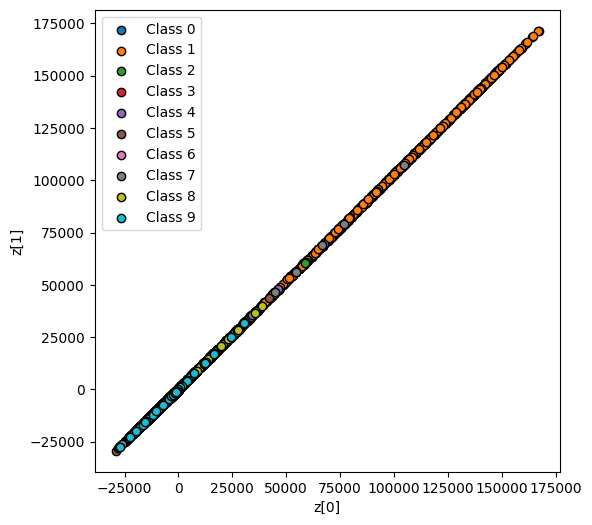

1/1 [==============================] - 0s 17ms/step


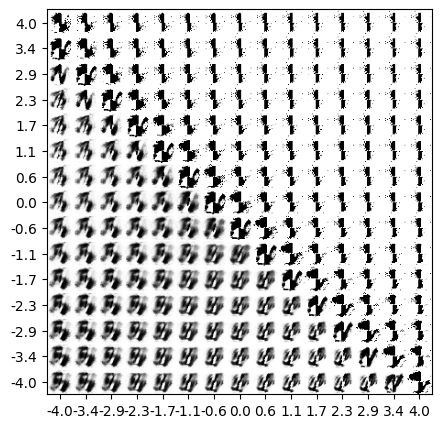

In [11]:
if __name__ == '__main__':
    encoder, decoder, vae = build_vae()
    vae.compile(optimizer='adam')
    vae.summary()
    vae.fit(x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test, None))
    plot_latent_distribution(encoder,x_test,y_test,batch_size=128)
    plot_generated_images(decoder)


In [12]:
# Save the trained VAE model to a file
with open('./vae_model.pkl', 'wb') as model_file:
    pickle.dump(vae, model_file)
# Load the VAE model from the file
with open('./vae_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)



ValueError: Layer 'dense' expected 2 variables, but received 0 variables during loading. Expected: ['dense/kernel:0', 'dense/bias:0']